# CRF (and NN) for Named Entity Recognition

Based on https://github.com/aminaghoul/NER-PyTorch

In this notebook we use conditional random fields (CRFs) which are generally used for named entity recognition in order to predict valid sequences.

For the CRF implementation, we will use the package [pytorch-crf](https://github.com/kmkurn/pytorch-crf).

In [16]:
!pip install torchtext==0.6.0 pytorch-crf


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import time
from torch.optim import Adam
from torchtext.data import Field, BucketIterator
from torchtext.datasets import SequenceTaggingDataset
from torchtext.vocab import Vocab
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import spacy
from torchcrf import CRF
import numpy as np
import pandas as pd

import time
import random
import string
from itertools import chain

In [18]:
# if you are working with colab gpu
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

# Data preparation

In [19]:
!mkdir data_ner

�������� ��� 䠩� data_ner 㦥 �������.


In [20]:
! wget https://github.com/aminaghoul/NER-PyTorch/raw/master/data/train.csv && mv train.csv data_ner/

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [21]:
! wget https://github.com/aminaghoul/NER-PyTorch/raw/master/data/valid.csv && mv valid.csv data_ner/

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [22]:
! wget https://github.com/aminaghoul/NER-PyTorch/raw/master/data/test.csv && mv test.csv data_ner/

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [23]:
# for the sake of reproducubility
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Torchtext [documentation](https://torchtext.readthedocs.io/en/latest/data.html)

In [24]:
TEXT = data.Field(lower = False) # creating an object for further transformations
TAG = data.Field(unk_token = None) # all the tags are known thus we set unk_token = None

my_path = "data_ner/"
train_data, valid_data, test_data = data.TabularDataset.splits(
        path= my_path ,
        train="train.csv",
        validation="valid.csv",
        test="test.csv", format='csv', skip_header=True,
        fields=(("text", TEXT), ("tag", TAG))
    )
MIN_FREQ = 0

TEXT.build_vocab(train_data,
                 min_freq = MIN_FREQ, # the words with frequency less than MIN_FREQ will be ignored and do not appear in the vocabulary
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)


TAG.build_vocab(train_data)
BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device, sort=False)

# padding index
TEXT_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
TAG_PAD_IDX = TAG.vocab.stoi[TAG.pad_token]

.vector_cache\glove.6B.zip: 862MB [14:12, 1.01MB/s]                               
100%|█████████▉| 399999/400000 [00:43<00:00, 9277.21it/s] 


In [25]:
len(TEXT.vocab.stoi)

23626

In [26]:
len(TAG.vocab.stoi)

10

In [27]:
TAG.vocab.itos

['<pad>',
 'O',
 'B-LOC',
 'B-PER',
 'B-ORG',
 'I-PER',
 'I-ORG',
 'B-MISC',
 'I-LOC',
 'I-MISC']

# Building the model

For the model class, there are three main features:

1. Prepare the CRF layer during initialization. We need to specify the number of possible tags in the text.
2. include the logic of the CRF layer in the sequence `forward()`. There is a major change in the `forward()` due to the implementation of the `pytorch-crf` package. So far, we do forward propagation and loss calculation separately. Loss calculations are now integrated with forward propagation.
3. Initialize all impossible transitions with a really low number (-100) in the `init_crf_transitions` function. This is where we impose the BIO sequence logic on the model.

More in-depth explaination and crf code from scratch can be found [here](https://towardsdatascience.com/implementing-a-linear-chain-conditional-random-field-crf-in-pytorch-16b0b9c4b4ea)

In [28]:
class NNCRF(nn.Module):
    def __init__(self,
                 input_dim,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 emb_dropout,
                 fc_dropout,
                 word_pad_idx,
                 tag_pad_idx):
        super().__init__()

        # LAYER 1: Word Embedding
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=embedding_dim,
            padding_idx=word_pad_idx
        ) # building input features (can be different)
        self.emb_dropout = nn.Dropout(emb_dropout)

        # LAYER 2: Fully-connected
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(embedding_dim, hidden_dim * 2)

        # LAYER 3: Fully-connected
        self.fc_dropout2 = nn.Dropout(fc_dropout)
        self.fc2 = nn.Linear(hidden_dim * 2, output_dim)

        # LAYER 4: CRF
        # computes the log likelihood of the given sequence of tags
        self.tag_pad_idx = tag_pad_idx
        self.crf = CRF(num_tags=output_dim)

        # init params with normal distribution
        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)

    def forward(self, words, tags=None):
        # words = [sentence length, batch size]
        # tags = [sentence length, batch size]

        # embedding_out = [sentence length, batch size, embedding dim]
        embedding_out = self.emb_dropout(self.embedding(words))

        # fc_out = [sentence length, batch size, hidden dim * 2]
        fc_out = self.fc(self.fc_dropout(embedding_out))

        # fc_out2 = [sentence length, batch size, output dim]
        fc_out2 = self.fc2(self.fc_dropout2(fc_out))

        if tags is not None:
            mask = tags != self.tag_pad_idx # we extract only valid positions not to consider padding a transition
            crf_out = self.crf.decode(fc_out2, mask=mask)
            crf_loss = -self.crf(fc_out2, tags=tags, mask=mask)
        else:
            crf_out = self.crf.decode(fc_out2)
            crf_loss = None

        return crf_out, crf_loss



    def init_crf_transitions(self, tag_names, imp_value=-100):
      # defining restrictions
        num_tags = len(tag_names)
        for i in range(num_tags):
            tag_name = tag_names[i]
            # I and <pad> cannot be in the beginning
            if tag_name[0] == "I" or tag_name == "<pad>":
                torch.nn.init.constant_(self.crf.start_transitions[i], imp_value)
        # O - I transition is impossible, it should always go through B
        tag_is = {}
        for tag_position in ("B", "I", "O"):

            tag_is[tag_position] = [i for i, tag in enumerate(tag_names) if tag[0] == tag_position]
        # {'B': [2, 3, 4, 7], 'I': [5, 6, 8, 9], 'O': [1]}
        impossible_transitions_position = {
            "O": "I"

        }
        # Inserting -100 for all impossible positions
        for from_tag, to_tag_list in impossible_transitions_position.items():
            to_tags = list(to_tag_list)

            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:

                        torch.nn.init.constant_(
                            self.crf.transitions[from_tag_i, to_tag_i], imp_value
                        )
        # impossible transitions between different types
        # B-LOC I-ORG
        impossible_transitions_tags = {
            "B": "I",
            "I": "I"
        }
        for from_tag, to_tag_list in impossible_transitions_tags.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        if tag_names[from_tag_i].split("-")[1] != tag_names[to_tag_i].split("-")[1]:
                            torch.nn.init.constant_(
                                self.crf.transitions[from_tag_i, to_tag_i], imp_value
                            )

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [29]:
embedding_dim=100
tag_pad_idx=TAG_PAD_IDX
model = NNCRF(
    input_dim=len(TEXT.vocab),
    embedding_dim=100,
    hidden_dim=256,
    output_dim=len(TAG.vocab),
    emb_dropout=0.1,
    fc_dropout=0.1,
    word_pad_idx=TEXT_PAD_IDX,
    tag_pad_idx=TAG_PAD_IDX
)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[tag_pad_idx] = torch.zeros(embedding_dim)

# CRF transitions initialisation
model.init_crf_transitions(
    tag_names=TAG.vocab.itos
)
print(f"The model has {model.count_parameters():,} trainable parameters.")

The model has 2,419,562 trainable parameters.


In [30]:
model

NNCRF(
  (embedding): Embedding(23626, 100, padding_idx=1)
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (fc_dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=100, out_features=512, bias=True)
  (fc_dropout2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (crf): CRF(num_tags=10)
)

In [31]:
for parameter in model.parameters():
    print(parameter)

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.0823,  0.3968,  0.6859,  ...,  0.0866, -0.0148, -0.1637],
        [-0.3110, -0.3398,  1.0308,  ...,  0.5317,  0.2836, -0.0640],
        [-0.5832, -0.5807,  0.3504,  ...,  0.4043, -0.0192,  0.0945]],
       requires_grad=True)
Parameter containing:
tensor([[-0.1041, -0.0050,  0.0329,  ..., -0.0215,  0.0901,  0.0447],
        [-0.0763,  0.1699, -0.1638,  ..., -0.0353,  0.0369,  0.1010],
        [-0.0044,  0.1073, -0.0730,  ..., -0.0029, -0.0146,  0.1497],
        ...,
        [-0.1933,  0.0658,  0.0263,  ...,  0.1111, -0.0086, -0.0561],
        [-0.0738, -0.0640,  0.0794,  ...,  0.1545, -0.0464, -0.0601],
        [ 0.1304,  0.1907,  0.1543,  ...,  0.0071,  0.1156,  0.1044]],
       requires_grad=True)
Parameter containing:
tensor([-0.1

We can access the transition matrix and make sure that the initialization is done as expected:

In [32]:
def print_crf_transitions(c, m):
    tags = TAG.vocab.itos
    max_len_tag = max([len(tag) for tag in tags])


    print("Start and end tag transitions:")
    print(f"{'TAG'.ljust(max_len_tag)}\tSTART\tEND")
    for tag, start_prob, end_prob in zip(tags, m.crf.start_transitions.tolist(), m.crf.end_transitions.tolist()):
        print(f"{tag.ljust(max_len_tag)}\t{round(start_prob, 2)}\t{round(end_prob, 2)}")
    print()


    print("Between tags transitions:")
    persons_i = [i for i, tag in enumerate(TAG.vocab.itos) if "PER" in tag or tag == "O"]
    max_len_tag = max([len(tag) for tag in TAG.vocab.itos if "PER" in tag ])
    transitions = m.crf.transitions
    to_tags = "TO".rjust(max_len_tag) + "\t" + "\t".join([tag.ljust(max_len_tag) for tag in tags if "PER" in tag or tag == "O"])
    print(to_tags)
    print("FROM")
    for from_tag_i, from_tag_probs in enumerate(transitions[persons_i]):
        to_tag_str = f"{tags[persons_i[from_tag_i]].ljust(max_len_tag)}"
        for to_tag_prob in from_tag_probs[persons_i]:
            to_tag_str += f"\t{str(round(to_tag_prob.item(), 2)).ljust(max_len_tag)}"
        print(to_tag_str)

print_crf_transitions(TEXT, model)

Start and end tag transitions:
TAG   	START	END
<pad> 	-100.0	0.2
O     	-0.2	-0.09
B-LOC 	-0.07	-0.09
B-PER 	0.05	-0.09
B-ORG 	-0.01	-0.09
I-PER 	-100.0	0.02
I-ORG 	-100.0	0.05
B-MISC	0.09	-0.01
I-LOC 	-100.0	0.06
I-MISC	-100.0	0.06

Between tags transitions:
   TO	O    	B-PER	I-PER
FROM
O    	0.02 	-0.26	-100.0
B-PER	0.03 	0.04 	0.05 
I-PER	-0.02	0.08 	0.09 


# Training

The outputs of the model are two lists: predictions and losses.
These changes are taken into account by modifying the function that computes the f-score.

 - Optimizer

 More on weight decay [here](https://github.com/dsgiitr/d2l-pytorch/blob/master/Ch06_Multilayer_Perceptrons/Weight_Decay.ipynb)

In [33]:
def opt(model, lr=1e-5, eps=1e-3, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    # 1. we don't want any decay for bias
    # 2. we want a decay for other parameters (fc weights, crf transitions)
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate}, # 2.
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]  # 1.

    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

optimizer = opt(model, lr=1e-3, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=1e-6, weight_decay=0.001) works too
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model = model.to(device)

 - Metrics

In [34]:
from sklearn.metrics import f1_score, classification_report

def f1_calc(preds, y, tag_pad_idx, full_report=False):
    index_o = TAG.vocab.stoi["O"]
    positive_labels = [i for i in range(len(TAG.vocab.itos))
                       if i not in (tag_pad_idx, index_o)] # we don't want to calculate metrics for padding
    # preds and ys - lists of lists
    flatten_preds = [pred for sent_pred in preds for pred in sent_pred]

    positive_preds = [pred for pred in flatten_preds
                      if pred not in (tag_pad_idx, index_o)]

    flatten_y = [tag for sent_tag in y for tag in sent_tag]
    if full_report:

        positive_names = [TAG.vocab.itos[i]
                              for i in range(len(TAG.vocab.itos))
                              if i not in (tag_pad_idx, index_o)]
        print(classification_report(
                y_true=flatten_y,
                y_pred=flatten_preds,
                labels=positive_labels,
                target_names=positive_names
            ))

    return f1_score(
            y_true=flatten_y,
            y_pred=flatten_preds,
            labels=positive_labels,
            average="micro"
        ), flatten_preds, flatten_y

In [35]:
def train(model, iterator, optimizer, tag_pad_idx):
    epoch_loss = 0
    epoch_f1 = 0
    model.train()

    for batch in iterator:

        text = batch.text
        tags = batch.tag

        optimizer.zero_grad()

        pred_tags_list, batch_loss = model(text, tags)

        # to calculate loss and F1 score we flatten true tags
        true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
            ]
        f1,_,_ = f1_calc(pred_tags_list, true_tags_list, tag_pad_idx)

        batch_loss.backward()

        optimizer.step()
        epoch_loss += batch_loss.item()
        epoch_f1 += f1

    return epoch_loss / len(iterator), epoch_f1 / len(iterator)

In [36]:
def evaluate(model, iterator, tag_pad_idx,full_report):
    epoch_loss = 0
    epoch_f1 = 0

    model.eval()
    preds = []
    labels = []
    with torch.no_grad():

        for batch in iterator:

            text = batch.text
            tags = batch.tag

            pred_tags_list, batch_loss = model(text, tags)
            true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
                ]

            f1, pred, lab = f1_calc(pred_tags_list, true_tags_list, tag_pad_idx, full_report)
            preds.append(pred)
            labels.append(lab)
            epoch_loss += batch_loss.item()
            epoch_f1 += f1

    return epoch_loss / len(iterator), epoch_f1 / len(iterator), preds, labels

In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10

In [38]:
t_loss = []
t_f1 = []
v_loss = []
v_f1 = []

best_valid_loss = float('inf')  # infinitely large
for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_f1 = train(model, train_iterator, optimizer, TAG_PAD_IDX)
    t_loss.append(train_loss)
    t_f1.append(train_f1)

    valid_loss, valid_f1 , _ , _ = evaluate(model, valid_iterator, TAG_PAD_IDX, full_report= False)
    v_loss.append(valid_loss)
    v_f1.append(valid_f1)

    scheduler.step()
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Saving the best checkpoint
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model_conll.pt')


    if epoch%1 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train F1 score: {train_f1*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1 score: {valid_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 24s
	Train Loss: 95.521 | Train F1 score: 26.75%
	 Val. Loss: 68.383 |  Val. F1 score: 41.63%
Epoch: 02 | Epoch Time: 3m 8s
	Train Loss: 63.719 | Train F1 score: 44.09%
	 Val. Loss: 54.352 |  Val. F1 score: 53.64%
Epoch: 03 | Epoch Time: 3m 14s
	Train Loss: 47.687 | Train F1 score: 56.63%
	 Val. Loss: 45.503 |  Val. F1 score: 62.91%
Epoch: 04 | Epoch Time: 2m 59s
	Train Loss: 36.520 | Train F1 score: 66.63%
	 Val. Loss: 39.669 |  Val. F1 score: 68.59%
Epoch: 05 | Epoch Time: 2m 59s
	Train Loss: 28.852 | Train F1 score: 73.95%
	 Val. Loss: 35.288 |  Val. F1 score: 72.31%
Epoch: 06 | Epoch Time: 2m 50s
	Train Loss: 23.397 | Train F1 score: 78.71%
	 Val. Loss: 33.778 |  Val. F1 score: 74.71%
Epoch: 07 | Epoch Time: 2m 41s
	Train Loss: 19.328 | Train F1 score: 82.48%
	 Val. Loss: 31.866 |  Val. F1 score: 75.75%
Epoch: 08 | Epoch Time: 2m 41s
	Train Loss: 16.286 | Train F1 score: 85.20%
	 Val. Loss: 30.638 |  Val. F1 score: 76.75%
Epoch: 09 | Epoch Time: 2m 11s
	T

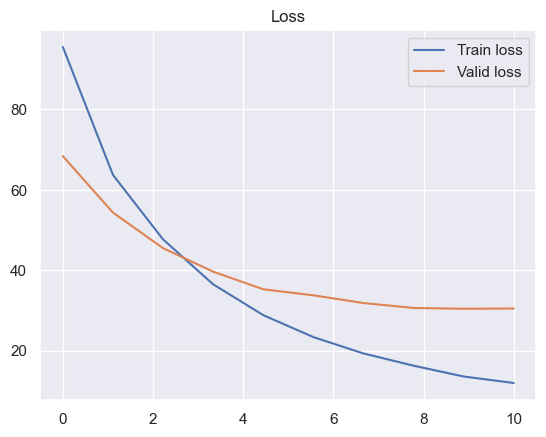

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()

x = np.linspace(0, N_EPOCHS, N_EPOCHS)

plt.plot(x, t_loss)
plt.plot(x, v_loss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])
plt.show()

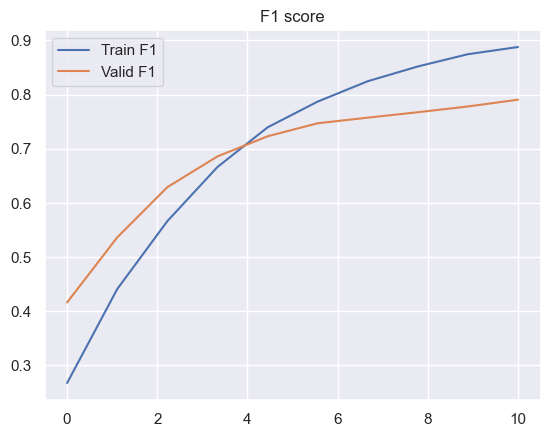

In [40]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_f1)
plt.plot(x,v_f1)
plt.title("F1 score")
plt.legend(["Train F1", "Valid F1"])
plt.show()

In [41]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
model.load_state_dict(torch.load('tut3-model_conll.pt'))

test_loss, test_f1, preds, labels = evaluate(model, test_iterator, TAG_PAD_IDX, full_report=False)
print(f'Test Loss: {test_loss:.3f} |  Test F1 score: {test_f1*100:.2f}%')

FileNotFoundError: [Errno 2] No such file or directory: 'tut3-model_conll.pt'

In [42]:
predict = [item for sublist in preds for item in sublist]
true = [item for sublist in labels for item in sublist]
confusion = confusion_matrix(true, predict)

NameError: name 'preds' is not defined

### Confusion matrix

In [ ]:
TAG.vocab.itos

['<pad>',
 'O',
 'B-LOC',
 'B-PER',
 'B-ORG',
 'I-PER',
 'I-ORG',
 'B-MISC',
 'I-LOC',
 'I-MISC']

In [ ]:
confusion_df = pd.DataFrame(confusion)

confusion_df.columns = [i for i in TAG.vocab.itos[1:]]
s = pd.Series([i for i in TAG.vocab.itos[1:]])
confusion_df = confusion_df.set_index([s])

confusion_df['LOC'] = confusion_df['B-LOC'] + confusion_df['I-LOC']
confusion_df['PER'] = confusion_df['B-PER'] + confusion_df['I-PER']
confusion_df['ORG'] = confusion_df['B-ORG'] + confusion_df['I-ORG']
confusion_df['MISC'] = confusion_df['B-MISC'] + confusion_df['I-MISC']


confusion_df = confusion_df.drop(columns=[ i for i in TAG.vocab.itos[1:] if i != 'O'])

confusion_df.loc['LOC'] = confusion_df.loc['B-LOC'] + confusion_df.loc['I-LOC']
confusion_df.loc['PER'] = confusion_df.loc['B-PER'] + confusion_df.loc['I-PER']
confusion_df.loc['ORG'] = confusion_df.loc['B-ORG'] + confusion_df.loc['I-ORG']
confusion_df.loc['MISC'] = confusion_df.loc['B-MISC'] + confusion_df.loc['I-MISC']

confusion_df = confusion_df.drop([i for i in TAG.vocab.itos[1:] if i != 'O'  ])

confusion_df

,O,LOC,PER,ORG,MISC
O,37147,73,715,486,99
LOC,174,1444,131,155,20
PER,317,37,2273,130,15
ORG,422,189,216,1625,42
MISC,134,14,67,58,642


### Precision-Recall-F1Score

Note that here we are evaluating type identification, not boundary detection

In [ ]:
cm = confusion_df.to_numpy()

TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)

prf_df = pd.DataFrame()
prf_df['Precision'] = precision
prf_df['Recall'] = recall
prf_df['F1-score'] = f1

s = pd.Series([i for i in confusion_df.index])
prf_df = prf_df.set_index([s])

prf_df

,Precision,Recall,F1-score
O,0.972587,0.964356,0.968454
LOC,0.821855,0.750520,0.784569
PER,0.668136,0.819986,0.736314
ORG,0.662184,0.651564,0.656831
MISC,0.784841,0.701639,0.740912


## Inference

In [ ]:
def tag_sentence(model, device, sentence, text_field, tag_field):

    model.eval()

    if isinstance(sentence, str):
        nlp = spacy.load('en_core_web_sm')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]

    max_word_len = max([len(token) for token in tokens])

    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]
    unk_idx = text_field.vocab.stoi[text_field.unk_token]
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]

    token_tensor = torch.as_tensor(numericalized_tokens)
    token_tensor = token_tensor.unsqueeze(-1).to(device)

    predictions, _ = model(token_tensor)
    predicted_tags = [tag_field.vocab.itos[t] for t in predictions[0]]

    return tokens, predicted_tags, unks

In [ ]:
example_index = 6

sentence = vars(valid_data.examples[example_index])['text'] # vars returns dict attribute of torchtext data example object
actual_tags = vars(valid_data.examples[example_index])['tag']

print(sentence)
print(actual_tags)

['Trailing', 'by', '213', ',', 'Somerset', 'got', 'a', 'solid', 'start', 'to', 'their', 'second', 'innings', 'before', 'Simmons', 'stepped', 'in', 'to', 'bundle', 'them', 'out', 'for', '174', '.']
['O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
tokens, pred_tags, unks = tag_sentence(model,
                                       device,
                                       sentence,
                                       TEXT,
                                       TAG
                                      )
print(pred_tags)
print(actual_tags)

['O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
print("Pred. Tag\t\t\t\tActual Tag\t\t\t\tCorrect?\t\t\t\tToken\n")
for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    space = 5 if pred_tag == 'O'else 4
    space1 = 5 if actual_tag == 'O'else 4
    print(pred_tag,"\t"*space, actual_tag, "\t"*space1, correct,"\t"*5, token)

Pred. Tag				Actual Tag				Correct?				Token

O 					 O 					 ✔ 					 Trailing
O 					 O 					 ✔ 					 by
O 					 O 					 ✔ 					 213
O 					 O 					 ✔ 					 ,
B-ORG 				 B-ORG 				 ✔ 					 Somerset
O 					 O 					 ✔ 					 got
O 					 O 					 ✔ 					 a
O 					 O 					 ✔ 					 solid
O 					 O 					 ✔ 					 start
O 					 O 					 ✔ 					 to
O 					 O 					 ✔ 					 their
O 					 O 					 ✔ 					 second
O 					 O 					 ✔ 					 innings
O 					 O 					 ✔ 					 before
B-PER 				 B-PER 				 ✔ 					 Simmons
O 					 O 					 ✔ 					 stepped
O 					 O 					 ✔ 					 in
O 					 O 					 ✔ 					 to
O 					 O 					 ✔ 					 bundle
O 					 O 					 ✔ 					 them
O 					 O 					 ✔ 					 out
O 					 O 					 ✔ 					 for
O 					 O 					 ✔ 					 174
O 					 O 					 ✔ 					 .


# Out-of-the-box method

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
sentence = 'The will deliver a speech about the conflict in North Korea tomorrow in New York with my friend Mary Kate.'
tokens, tags, unks = tag_sentence(model,
                                  device,
                                  sentence,
                                  TEXT,
                                  TAG
                                )

print("Pred. Tag\tToken\n")


for token, tag in zip(tokens, tags):
    space = 2 if tag == 'O'else 1
    print(tag, "\t"*space, token)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Pred. Tag	Token

O 		 The
O 		 will
O 		 deliver
O 		 a
O 		 speech
O 		 about
O 		 the
O 		 conflict
O 		 in
B-LOC 	 North
I-LOC 	 Korea
O 		 tomorrow
O 		 in
B-ORG 	 New
I-ORG 	 York
O 		 with
O 		 my
O 		 friend
B-PER 	 Mary
I-PER 	 Kate
O 		 .
